# Using Machine Learning to Predict Heterogeneous Treatment Effects

## Algorithms tailored for predicting outcomes can do poorly when predicting treatment effects

### Factors that strongly predict outcomes may not strongly predict treatment effects

$Y_i$: spending on a Lexus

$W_i$: seeing an online ad for a Lexus

$\ln Y_i=\beta_0+\beta_1 age_i +\beta_2 male_i + \beta_3 W_i+\beta_4 W_i \times male_i +\varepsilon_i$

How do outcomes vary by age? (A lot if $\beta_1$ is big)

How do treatment effects vary by age? (not at all!)

What do treatment effects vary by? (gender!)

In [1]:
# Install econml
!pip install econml

     |████████████████████████████████| 3.0MB 5.3MB/s 
     |████████████████████████████████| 133kB 36.4MB/s 
     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 358kB 39.6MB/s 
  Created wheel for shap: filename=shap-0.38.1-cp37-cp37m-linux_x86_64.whl size=490494 sha256=b73668dee8aeea2a6a31e05b4df9825296b21c545e5a26d8387d64e9e79796e0
  Stored in directory: /root/.cache/pip/wheels/a8/fb/e4/88012be41842b9be62ae18d82d1b1e880daf8539d1fef1fa00
Successfully built shap
  Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [2]:
# import useful packages
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split
from econml.ortho_forest import ContinuousTreatmentOrthoForest as CausalForest
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# define parameters
n = 1000 # sample size
p = .5 # probability of seeing the ad
beta0=0
beta1=.2 # effect of age
beta2=-.025 # difference in average spending between males and females who don't see the ad ()
beta3=0 # effect of treatment among females
beta4=.05 # differential effect of treatment among males compared to females
sigeps=.2 # residual variance of outcome

# generate some fake data
age=np.random.randint(low=18,high=61,size=(n,1))
male=np.random.randint(low=0,high=2,size=(n,1))
w=np.random.rand(n,1)>(1-p)
epsilon=sigeps*np.random.randn(n,1)
lny=beta0+beta1*age+beta2*male+beta3*w+beta4*w*male+epsilon

# assemble as dataframe
fakedata=pd.DataFrame(np.concatenate((lny,w,age,male),axis=1),columns=['lny','w','age','male'])
fakedata.feature_names=['age','male']

# fit trees
tree1 = DecisionTreeRegressor(max_depth=2)
tree1.fit(fakedata.loc[w==1,['age','male']],fakedata.loc[w==1,['lny']])
tree0 = DecisionTreeRegressor(max_depth=2)
tree0.fit(fakedata.loc[w==0,['age','male']],fakedata.loc[w==0,['lny']])

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Treated tree:


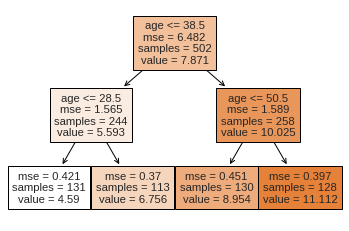

In [ ]:
# look at trees
print('Treated tree:')
d=tree.plot_tree(tree1,filled=True,feature_names=fakedata.feature_names) 

Untreated tree:


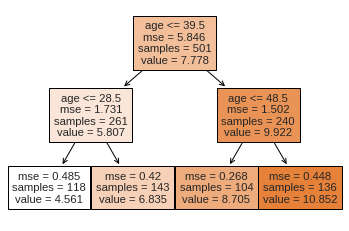

In [5]:
print('Untreated tree:')
d=tree.plot_tree(tree0,filled=True,feature_names=fakedata.feature_names) 

Note that both trees used only age. As a result, the predicted treatment effects will not vary at all by gender, which in reality is the only feature upon which treatment effects depend.



### Non-Honest trees can exaggerate differences between groups

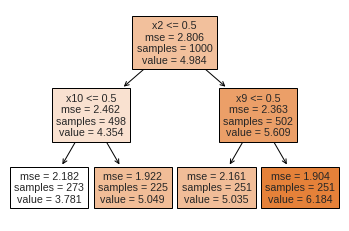

In [6]:
#generate a bunch of predictors:
x1=np.random.randint(low=0,high=2,size=(n,1))
x2=np.random.randint(low=0,high=2,size=(n,1))
x3=np.random.randint(low=0,high=2,size=(n,1))
x4=np.random.randint(low=0,high=2,size=(n,1))
x5=np.random.randint(low=0,high=2,size=(n,1))
x6=np.random.randint(low=0,high=2,size=(n,1))
x7=np.random.randint(low=0,high=2,size=(n,1))
x8=np.random.randint(low=0,high=2,size=(n,1))
x9=np.random.randint(low=0,high=2,size=(n,1))
x10=np.random.randint(low=0,high=2,size=(n,1))

# Each of these predictors affects the outcome with coefficient = 1:
y=x1+x2+x3+x4+x5+x6+x7+x8+x9+x10+epsilon

# Now grow a tree:
predictors=np.concatenate((x1,x2,x3,x4,x5,x6,x7,x8,x9,x10),axis=1)
predictor_names=['x1','x2','x3','x4','x5','x6','x7','x8','x9','x10']
dishonest=DecisionTreeRegressor(max_depth=2)
dishonest.fit(predictors,y)
d=tree.plot_tree(dishonest,filled=True,feature_names=predictor_names)


According to our "model" for y, what should be the difference between outcomes in neighboring leaves from the same node? (one!) What are the observed differences in the tree? (greater than one!)

Solution: Honest trees, or double-sample trees, use a subset of the training set to grow the tree, and another subset to estimate means in each leaf

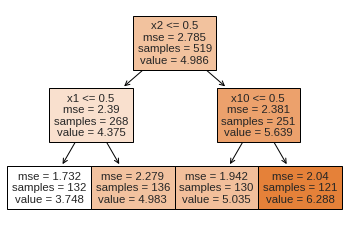

In [7]:
train=np.random.randint(low=0,high=2,size=n)==1

# Grow tree on training set:
dt = DecisionTreeRegressor(max_depth=2)
dt.fit(predictors[train,:],y[train])
d=tree.plot_tree(dt,filled=True,feature_names=predictor_names) 

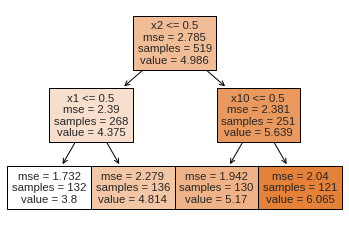

In [10]:
# But use estimation set to calculate means in each leaf:
leaves=dt.apply(predictors[~train])
yest=y[~train]
honest=dt
n_nodes = honest.tree_.node_count
for ii in range(n_nodes):
  if honest.tree_.children_left[ii]==-1: # means that the current node is a leaf
    estii=yest[leaves==ii]
    honest.tree_.value[ii]=estii.mean() # replace the leaf's value with the estimation set's mean

d=tree.plot_tree(honest,filled=True,feature_names=predictor_names) 

The leaf means are not nearly as extreme as in the "dishonest" tree that uses the training observations to construct the predictions

## Random Causal Forest

In [11]:
train, test = train_test_split(fakedata, test_size=0.2)
estimator = CausalForest(n_trees=100,
                         model_T=DecisionTreeRegressor(),
                         model_Y=DecisionTreeRegressor())
estimator.fit(train['lny'],
              train['w'],
              train[fakedata.feature_names],
              inference='blb')
effects_train = estimator.effect(train[fakedata.feature_names])
effects_test = estimator.effect(test[fakedata.feature_names])
conf_intrvl = estimator.effect_interval(test[fakedata.feature_names])

The econml.ortho_forest.ContinuousTreatmentOrthoForest class has been renamed to econml.orf.DMLOrthoForest; an upcoming release will remove support for the old name
X and W should be passed by keyword only. In a future release we will disallow passing X and W by position.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 163 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: D

In [12]:
malefx_train=effects_train[train['male'].values==1]
maleage_train=train['age'].iloc[train['male'].values==1]
malefx_train.mean()




In [13]:
femalefx_train=effects_train[train['male'].values==0]
femaleage_train=train['age'].iloc[train['male'].values==0]
femalefx_train.mean()

In [14]:
malefx_test=effects_test[test['male'].values==1]
malefx_test.mean()

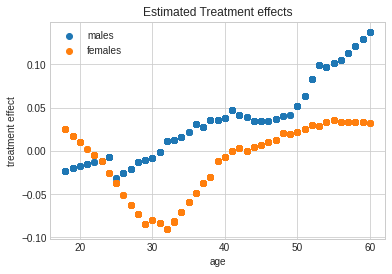

In [15]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(maleage_train,malefx_train,label='males');
ax.scatter(femaleage_train,femalefx_train,label='females');
ax.legend()
plt.title("Estimated Treatment effects")
plt.xlabel("age")
plt.ylabel("treatment effect");

Clearly doesn't nail the age profile (which should be flat) but does get the difference between men and women!

To do yourself: use the college dataset from the "controls" class example to investigate heterogeneity in the effects of attending an elite college. You can define a binary treatment variable equal to one for all colleges whose "matsat2" variable is above the average.